# Explanation

The variation auto-encoder (VAE) is designed to learn complex distributions with continuous variables that are subject to a lot of variations. Images are a perfect example of this - each pixel is represented by the continuous RGB values where each has $256^3$ possibilities, and each image can maintain a representation of the same object while individual pixels may be moved around or changed in value in a huge number of ways.

The VAE introduces a "stochastic variational inference" algorithm that can effectively model such complex distributions by incorporating probability and randomness directly into the model itself (rather than the prior deterministic structure of most neural networks).

The VQ VAE then introduces a discrete algorithm (that doesn't use randomness) inspired by the VAE that is effective at modeling similar distributions.

The common intuition shared between the VAE & the VQ VAE is that in highly complex distributions (like the one that creates images), reconstructing the data involves learning the lower dimensionality representations that encode the most important features (called the "modes" of the data), and then learning to add back into the complexity of the details on top of these features through some means.

### VAE

The VAE approaches this problem with an encoder-decoder architecture that forces the model to learn to separate out the high-level features from the complexity.

Specifically, it learns to pick out the high-level features explicitly, and then approximate the complexity with random sampling.

In probability, the aggregation of a large number of random variables often approximates to some far simpler distribution (usually the Gaussian distribution). This is the intuition behind the VAE.

Instead of trying to learn the complexity directly, the VAE learns to pick out features by compressing data into two representation vectors: the $\mu$ and $\sigma$ vectors which represent the mean and variance of a Gaussian distribution. Then, in order to actually synthesize specific images, it samples from this distribution (adding back complexity).

The VAE consists of two parts:

1. The encoder, which produces the $\mu$ and $\sigma$ vectors for each input value (which should correspond with the high-level features)
2. The decoder, which samples from a Gaussian distribution with the $\mu$ and $\sigma$ values, and then uses this sampled vector to recreate the image.

The overall model is trained my trying to maximize the likelihood that the decoder reproduces the image from the vector sampled from encoders representation, forcing the encoder to push it's encoded vectors closer to the modes of the dataset, and allowing the random sampling to approximate the complexity.

Importantly, adding randomness between the encoder and decoder introduces a non-differentiable step that would cut off the gradient flow from the decoder back through to the encoder. The VAE solves this using the **reparameterization trick**, which isolates the randomness term by sampling vectors via $z = \mu + \sigma \cdot \epsilon$, where gradient can still flow back through $\sigma$ and $\mu$, and the randomness is isolated to $\epsilon$ which can be independently sampled, rather than making $z$ just directly sample from a Gaussian distribution.

### VQ VAE

The VQ VAE still effectively learns to separately model the modes and complexity in its training distribution, but it no longer uses randomness directly in the model.

Instead, the VQ VAE encoder outputs vectors which are then "quantized" to fit into a finite codebook of $K$ vectors before passing to the decoder. In other words, the VQ VAE maintains a list of a finite number of vectors, and for each vector outputted by the decoder, it replaces that vector with the nearest vector in the codebook before passing it to the decoder.

Through the training process, the VQ VAE updates this codebook to make it more effective for the decoder to reproduce the images.

In this way, the VQ VAE is actually trianing 3 separate parts of the model:
1. The decoder has to use the codebook to effectively reproduce images
2. The codebook has to update its embedding vectors to be most useful to the decoder (and most representative of the images)
3. The encoder has to encode vectors to be close to their most representative forms in the code book.

This process forces the VQ VAE to learn discrete representations of the inputs, which forces it to encode the most essential information.

Because of the quantization process, there's a "quantization-error" that comes from some of the complexity being removed by the model due to snapping the vectors produced by the encoder directly into codebok vectors. This forces the decoder to learn to add back the complexity in the data based on lower-dimensional representations from the codebook.

During training, the model has to make the encoder produce better representations, and make the decoder produce images from the quantized representations, but it also has to optimize the codebook. These concerns are represented in the loss function:

$$
L = \log p(x|z_q(x)) + || \textrm{sg}[z_e(x)] - e ||_2^2 | - \beta || z_e(x) - sg[e] ||_2^2
$$

The left most term here represents the objective for the encoder and decoder to work together to reconstruct the image (the standard task of the auto-encoder).

The second term minimizes the distance between the encoders outputs and the embeddings in the codebook, which is what actually improves the utility of the codebook.

The third term can be thought of as a "commmitment loss" which forces the encoder to move its encoded vectors close to the codebook vectors, preventing these 2 from optimizing separately and diverging.

The VQ VAE proves effective at reconstructing images, meeting the quality of GANs - and it was also the generative model of choice for OpenAI's original DALL E model.





# My Notes

## 📜 [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114)

> How can we perform efficient inference and learning in directed probabilistic models, in the presence of continuous latent variables with intractable posterior distributions, and large datasets?

How do we make probabilistic models (where parts of the feed-forward process come from sampling from a distribution, rather than all being deterministic) on large datasets where the apparent data generating distribution is continuous an intractable?

An example of this is large image datasets, where the actual distribution producing each image is extremely complex, as lots of noise is permitted and image content will still remain the same (this is an indicator of the complexity of the distribution - you have to account for so many possibilities, which are all continuous in terms of pixel values and positions).

> We introduce a stochastic variational inference and learning algorithm that scales to large datasets and, under some mild differentiability conditions, even works in the intractable case.

**variational inference algorithm** - an algorithm that models the true (intractable) distribution of the data with a much simpler variational distribution, like the Gaussian distribution, which allows simpler inference

Importantly, modeling the true distribution with a simpler and differentiable distributions means we can actually compute gradients

> We show that a re-parameterization of the variational lower bound
> yields a lower bound estimator that can be straightforwardly optimized using standard stochastic gradient methods.

One of the most important contributions of the paper - they provide a way to alter the random sampling component (from a Gaussian) usually present in the variational lower bound optimization (explained later) that makes the random sampling actually differentiable.

This is critical - this innovation makes it actually possible to use stochastic gradient descent and deep neural networks with back-propagation to optimize probabilistic models.

> Second, we show that for i.i.d. datasets with continuous latent variables per datapoint, posterior inference can be made especially efficient by fitting an approximate inference model (also called a recognition model) to the intractable posterior using the proposed lower bound estimator.

Another key innovation - they show that you can model the extremely complex and unknown posterior distribution with a separate internal distribution in the model, which can be tuned, and then used to run inference.

This recognition model can be optimized using the lower bound estimator.

> The variational Bayesian (VB) approach involves the optimization of an approximation to the intractable posterior.

The inspiration behind the VAE approach from statistics. The variational Bayesian approach, which models a more complex distribution with a simpler one (like the Gaussian).

> Unfortunately, the common mean-field approach requires analytical solutions of expectations w.r.t. the approximate posterior, which are also intractable in the general case.

The usual approach to VB is the “mean-field” approach which involves calculating an expectation of conditional probabilities based on random variables sampled from a distribution - and as a result often involves integrating over CDFs which takes “analytical solutions” that are often intractable.

> We show how a re-parameterization of the variational lower bound yields a simple differentiable unbiased estimator of the lower bound; this SGVB (Stochastic Gradient Variational Bayes) estimator can be used for efficient approximate posterior inference in almost any model with continuous latent variables and/or parameters, and is straightforward to optimize using standard stochastic gradient ascent techniques.

They introduce a new method that updates on this VB method to make it usable in stochastic gradient descent by addressing the problems brought up above.

> We propose the AutoEncoding VB (AEVB) algorithm. In the AEVB algorithm we make inference and learning especially efficient by using the SGVB estimator to optimize a recognition model that allows us to perform very efficient approximate posterior inference using simple ancestral sampling

They create a joint model where one part learns to form a recognition model that approximates the more complex data generating distribution, and then an inference model that samples from this distribution to reproduce the original values.

> Which in turn allows us to efficiently learn the model parameters, without the need of expensive iterative inference schemes (such as MCMC) per datapoint.

This architecture with both a recognition model and an inference model forces the recognition model to encode useful representations that can be reinterpreted back to the original data.

This method is far more efficient than previous methods that require long chains of compute like Markov Chain Monte Carlo to accomplish the same thing.

> When a neural network is used for the recognition model, we arrive at the variational auto-encoder.

### Method

> We will restrict ourselves […] to […] where we like to perform maximum likelihood (ML) or maximum a posteriori (MAP) inference on the (global) parameters, and variational inference on the latent variables.

**1. Problem Scenario**

We deal with situations where we have some dataset $X = \{ x^{(i)} \}_{i=1}^N$ that consists of a process of values where (1) some values $z^{(i)}$ are generated from some distribution $p_{\theta^*}(z)$ and (2) the values $x^{(i)}$ are drawn from $p_{\theta^*}(x|z)$, and that their PDFs are tractable, but that calculating the integral of the marginal likelihood $\int p_\theta(z) p\theta(x|z) dz$ (necessary to calculate the evidence lower bound) is intractable.

> We are interested in, and propose a solution to, three related problems in the above scenario:

1. Efficient approximate ML or MAP estimation for the parameters $\theta$. The parameters […] allow us to mimic the hidden random process and generate artifical data that resembles the real data.

2. Efficient approximate posterior inference of the latent variable $z$ given an observed value $x$ for a choice of parameters $\theta$. This is useful for coding or data representation tasks.

3. Efficient approximate marginal inference of the variable $x$. This allows us to perform all kinds of inference tasks where a prior over $x$ is required. Common applications in computer vision include image denoising, in-painting and super-resolution.
   >

Each of these 3 objectives provides real value that will become important. The representation space created by the encoder becomes very valuable (and can even be used for embeddings).

Additionally, the inference part can be used for many image generation and manipulation applications.

We introduce a “recognition model” $q_\phi(z|x)$ meant to model the true posterior distribution, which will be called the _encoder_. Then, the distribution $p_\theta(x|z)$ will be called the _decoder_.

**1. The Variational Bound**

> The marginal likelihood is composed of a sum over the marginal likelihoods of individual datapoints $\log p_\theta(x^{(1)}, …, x^{(N)}) = \sum_{i=1}^N \log p_\theta(x^{(i)})$, which can be rewritten as:

$$
\log p_\theta(x^{(i)}) = D_{KL}(q_\phi(z|x^{(i)}), p_\theta(z|x^{(i)})) + \mathcal{L}(\theta, \phi; x^{(i)})
$$

The KL divergence models the difference between our approximate distribution and the true distribution of the latent variables $z$ given the actual sampled value $x^{(i)}$.

The second term $\mathcal{L}$, known as the _variational lower bound_, marks the lower bound of the probability of any observed data-point appearing in our distribution:

$$
\log p_\theta(x^{(i)}) \geq \mathcal{L}(\theta, \phi; x^{(i)}) = \mathbb{E}_{q_\phi(z|x)}[-\log q_\phi(z|x) + \log p_\theta(x,z)]
$$

This term represents the evidence lower bound. We take the expectation of values sampled over our approximate distribution $q_\phi$ for all values $z$ sampled given $x$, weighted by their relative probabilities.

For each, we want to maximize the first term (the entropy) $- \log q_\phi(z|x)$, which means minimizing the probability of $z$ being sampled given $x$ generally. This spreads out the distribution more, preventing $z$ from concentrating around too few values.

The second term $\log p_\theta(x,z)$ ensures that our model learns useful representations for $z$ that allow the decoder to actually reconstruct $x$.

These two terms work together to make the ELBO effective. The first term can be thought of as saying “explore a broad range of possibilities for $z$ for each $x$, instead of narrowing down” forcing the distribution to be very spread out (different $z$ values should not be highly used across the model).

Meanwhile, the second term is saying “focus on the values of $z$ that effectively help the decoder to recreate $x$.”

We can then rewrite the above equation for the ELBO using the KL divergence as follows:

$$
\mathcal{L}(\theta, \phi; x^{(i)}) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(z) + \log p_\theta(x|z) - \log q_\phi(z|x)] \\
D_{KL}(q_\phi(z|x), p_\theta(z)) = \mathbb{E}_{q_\phi(z|x)}[\log q_\theta(z|x) - \log p_\theta(z)] \\
\mathcal{L}(\theta, \phi; x^{(i)}) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x), p_\theta(z))
$$

Thus, the first term of this maximizes the probability that our decoder can produce $x$ from the $z$ values sampled from the encoder, and the second term minimizes the difference between the approximate distributions condition $z|x$ and the overall sampling of $z$.

**3. The SGVB Estimator and AEVB Algorithm**

> In this section we introduce a practical estimator of the lower bound and its derivates w.r.t the parameters.

Here, we address the ability to model our evidence lower bound for maximization with an efficient estimator.

> Under certain mild conditions […] for a chosen approximate posterior $q_\phi (z|x)$ we can reparameterize random variable $\hat{z} \sim q_\phi(z|x)$ using a differentiable transformation $g_\phi(\epsilon, x)$ of an (auxiliary) noise variable $\epsilon$

$$
\hat{z} = g_\phi(\epsilon, x) \textrm{ with } \epsilon \sim p(\epsilon) \\
E_{q_\phi(z|x^{(i)})}[f(z)] = E_{p(\epsilon)}[f(g_\phi(\epsilon, x^{(i)}))] \simeq \frac{1}{L} \sum_{l=1}^L f(g_\phi(\epsilon^{(l)}, x^{(i)})) \\
$$

Here, we create a re-parameterized estimator introducing some random noise through the variable $\epsilon$ which introduces noise. Then, you can take the expectation by taking the average over a number of samples influenced by this random noise, rather than calculating the integral through analytical means.

We can apply this sampling method to our calculation of $\mathcal{L}$ to create an estimator function $\mathcal{L}^A(\theta, \phi; x)$ that can be used to optimize the ELBO.

> The KL-divergence term can then be interpreted as regularizing $\phi$, encouraging the approximate posterior to be close to the prior $p_\theta(z)$.

> A connection with auto-encoders becomes clear when looking at the objective function. The first term is (the KL divergence of the approximate posterior from the prior) acts as a regularizer, while the second term is a an expected negative reconstruction error.

**4. The re-parameterization trick**

> The essential parameterization trick is quite simple. Let $z$ be a continuos random variable, and $z \sim q_\phi(z|x)$ be some conditional distribution. It is then often possible to express the random variable $z$ as a deterministic variable $z = g_\phi(\epsilon, x)$ where $\epsilon$ is an auxiliary variable with independent marginal $p(\epsilon)$ and $g_\phi(.)$ is some vector-valued function parameterized by $\phi$.

This reframing (re-parameterization) allows us to make the sampling of the random variable $z$ differentiable (via the parameters $\phi$) by isolating the noise to a separate variable $\epsilon$.

> Take, for example, the univariate Gaussian case: let $z \sim p(x|x) = \mathcal{N}(\mu, \sigma^2)$. In this case, a valid re-parameterization is $z = \mu + \sigma\epsilon$, where $\epsilon$ is an auxiliary noise variable $\epsilon \sim \mathcal{N}(0,1)$.

### Experiments

> We trained generative models of images from the MNIST and Frey Face datasets and compared learning algorithms in terms of the variational lower bound, and the estimated marginal likelihood.

![Screenshot 2024-05-18 at 11.58.38 AM.png](../../images/Screenshot_2024-05-18_at_11.58.38_AM.png)

### Conclusion

> We have introduce a novel estimator of the variational lower bound, Stochastic Gradient VB (SGVB), for efficient approximate inference with continuous latent variables.

> The theoretical advantages are reflected in experimental results.


## 📜 [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937)

> In this paper, we propose a simple yet powerful generative model that learns […] discrete representations [without supervision].

> Our model, the Vector Quantized Variational Auto Encoder (VQ-VAE), differs from VAEs in two key ways: the encoder network outputs discrete, rather than continuous, codes; and the prior is learnt rather than static.

> Pairing these representations with an autoregressive prior, the model can generate high quality images, videos, and speech as well as doing high quality speaker conversion and unsupervised learning of phonemes, providing further evidence of the utility of the learnt representations.

> Our goal is to achieve a model that conserves the important features of the data in its latent space while optimizing for maximum likelihood.

> In this paper, we argue for learning discrete and useful latent variables, which we demonstrate on a variety of domains.

> Learning representations with continuous features have been the focus of many previous work, however we concentrate on discrete representations which are potentially a more natural fit for many of the modalities we are interested in.

They observe that many data distributions including text, and even images given that they can be described by text, can be represented in discrete ways.

> Our model, which relies on vector quantization (VQ), is simple to train, does not suffer from large variance, and avoids the “posterior collapse” issue which has been problematic with many VAE models that have a powerful decoder, often caused by latents being ignored.

### VQ-VAE

> VAEs consist of the following parts: an encoder network which parameterizes a posterior distribution $q(z|x)$ of discrete latent random variables $z$ given the input data $x$, a prior distribution $p(z)$, and a decoder with a distribution $p(x|z)$ over input data.

**1. Discrete Latent Variables**

> We define a latent embedding space $e \in R^{K \times D}$ where $K$ is the size of the discrete latent space, and $D$ is the dimensionality of each latent embedding vector $e_i$

This model uses an encoder producing an output $z_e(x)$ for each input $x$.

Then, this value $z_e(x)$ is passed through a posterior categoorical distribution that collapses the output value into 1-of-K embedding vectors

$$
q(z = k|x) = \begin{cases}
  1 & \textrm{for } k = \textrm{argmin}_j || z_e(x) - e_j ||_2 \\
  0 & \textrm{otherwise}
\end{cases}
$$

> The representation $z_e(x)$ is passed through a discretisation bottleneck followed by mapping onto the nearest element of embedding $e$.

**2. Learning**

Since $q(z)$ has no gradient, we just copy over the gradient from decoder input $z_q(x)$ to encoder output $z_e(x)$.

> Due to the straight-through gradient estimation of mapping from $z_e(x)$ to $z_q(x)$, the embeddings $e_i$ receive no gradients from the reconstruction loss $\log p(z|z_q(x))$. Therefore, in order to learn the embedding space, we use one of the simplest dictionary learning algorithms, Vector Quantization (VQ).

> The VQ objective uses the $l_2$ error to move the embedding vectors $e_i$ towards the encoder outputs $z_e(x)$.

The actual embedding space is disconnected from the main gradient flow directly, and instead is just built to minimize the overall distance between the embedding vectors and the actual encoder outputs (maximizing the utility of each embedding to matching a variety of the outputs).

> To make sure the encoder commits to an embedding and its output does not grow, we add a commitment loss, the third term in the [loss equation]. Thus, the total training objective becomes:

$$
L = \log p(x|z_q(x)) + || \textrm{sg}[z_e(x)] - e ||_2^2 | - \beta || z_e(x) - sg[e] ||_2^2
$$

> where _sg_ stands for the stop-gradient operator that is defined as identity at forward computation time and has zero partial derivatives, thus effectively constraining its operand to be a non-updated constant.

The first term (familiar from VAEs) tries to maximize the probability that $x$ is regenerated given the latents (embeddings) created by $z_q(x) = q(z_e(x))$ from the encoder and categorization.

The second term minimizes the $L_2$ distance between the embedding vectors and the encoder outputs.

The third term ensures that the encoder commits to its choice of embeddings and moves its encoded outputs closer to them so that the encoder outputs don’t slowly start to diverge from the embedding choices.

**3. Prior**

> The prior distribution over the discrete latents $p(z)$ is a categorical distribution, and can be mad autoregressive by depending on other $z$ in the feature map. Whilst training the VQ-VAE, the prior is kept constant and uniform.

> After training, we fit an autoregressive distribution over $z$, $p(z)$, so that we can generate $x$ via ancestral sampling.

### Experiments

**1. Comparison with Continuous Variables**

> Our model is the first among those using discrete latent variables which challenges the performance of continuous VAEs.

**2. Images**

> Images contain a lot of redundant information as most of the pixels are correlated and noisy, therefore learning models at the pixel level could be wasteful.

> In this experiment we show that we can model $x = 128 \times 128 \times 3$ images by compressing them to a $z = 32 \times 32 \times 1$ discrete space (with $K=512$) via a purely de-convolutional $p(x|z)$.

> We model images by learning a powerful prior (PixelCNN) over $z$.

![Screenshot 2024-05-18 at 12.46.00 PM.png](../../images/Screenshot_2024-05-18_at_12.46.00_PM.png)

![Screenshot 2024-05-18 at 12.46.35 PM.png](../../images/Screenshot_2024-05-18_at_12.46.35_PM.png)

**3. Audio**

> In all our audio experiments, we train a VQ-VAE that has a dilated convolutional architecture similar to WaveNet decoder.

> This means that the VQ-VAE has, without any form of linguistic supervision, learned a high-level abstract space that is invariant to low-level features and only encodes the content of the speech.

**4. Video**

> It can be seen that the model has learnt to successfully generate a sequence of frames conditioned on given action without any degradation in the visual quality whilst keeping the local geometry correct.

![Screenshot 2024-05-18 at 12.51.34 PM.png](../../images/Screenshot_2024-05-18_at_12.51.34_PM.png)

### Conclusion

> In this work we have introduced VQ-VAE, a new family of models that combine VAEs with vector quantization to obtain a discrete latent representation.

> We have shown that VQ-VAEs are capable of modeling very long term dependencies through their compressed discrete latent space which we have demonstrated by generating 128 × 128 color images, sampling action conditional video sequences and finally using audio where even an unconditional model can generate surprisingly meaningful chunks of speech and doing speaker conversion.

> All these experiments demonstrated that the discrete latent space learnt by VQ-VAEs capture important features of the data in a completely unsupervised manner.


### 📜 [Generating Diverse High-Fidelity Images with VQ-VAE 2](https://arxiv.org/pdf/1906.00446)

> We scale and enhance the autoregressive priors used in VQ-VAE to generate synthetic samples of much higher coherence and fidelity than possible before.

> We demonstrate that a multi-scale hierarchical organization of VQ-VAE, augmented with powerful priors over the latent codes, is able to generate samples with quality that rivals that of state of the art Generative Adversarial Networks on multifaceted datasets such as ImageNet, while not suffering from GAN’s known shortcomings such as mode collapse and lack of diversity

> It is well known that samples from [GANs] do not fully capture the diversity of the true distribution.

> In contrast, likelihood based methods optimize negative log-likelihood (NLL) of the training data. This objective allows model-comparison and measuring generalization to unseen data.

> In this paper we use ideas from lossy compression to relieve the generative model from modeling negligible information.

### Background

**1. Vector Quantized Variational Auto Encoder**

> The VQ-VAE model can be better understood as a communication system. It comprises of an encoder that maps observations onto a sequence of discrete latent variables, and a decoder that reconstructs the observations from these discrete variables. Both encoder and decoder use a shared codebook.

The VQ-VAE has a _codebook_ that it uses to communicate between the encoder and the decoder.

The decoder maps the received indices of vectors in the codebook and uses it to reconstruct the original data via non-linearities. This is the “regeneration loss.”

In addition, the VQ-VAE has _codebook loss_ to make the codebook match more closely with the encoder outputs, and the _commitment loss_ to encourage the output of the decoder to stay closer to the codebook.

$$
\mathcal{L}(x, D(e)) = ||x - D(e)||_2^2 + ||sg[E(x)] - e||_2^2 + \beta || sg[e] - E(x) ||_2^2
$$

**2. PixelCNN Family of Autoregressive Models**

> Deep autoregressive models are common probabilistic models that achieve state of the art results in density estimation across several data modalities.

### Method

> The proposed method follows a two-stage approach: first, we train a hierarchical VQ-VAE to encode images onto a discrete latent space, and then we fit a powerful PixelCNN prior over the discrete latent space induced by all the data.

This sets the intuition for transformer based image generation with VQ-VAEs as well - the place where PixelCNN is operating now can be replaced with a transformer with self-attention to learn the distribution.

![Screenshot 2024-05-18 at 1.28.31 PM.png](../../images/Screenshot_2024-05-18_at_1.28.31_PM.png)

**1. Stage 1: Learning Hierarchical Latent Codes**

> As opposed to vanilla VQ-VAE, in this work we use a hierarchy of vector quantized codes to model large images. The main motivation behind this is to model local information, such as texture, separately from global information such as shape and geometry of objects.

> The prior model over each level can thus be tailored to capture the specific correlations that exist in that level.

> The structure of our multi-scale hierarchical encoder [has] a top latent code which models global information, and a bottom latent code, conditioned on the top latent, responsible for representing local details.

**2. Stage 2: Learning Priors over Latent Codes**

> In order to further compress the image, and to be able to sample from the model learned during, we learn a prior over the latent codes

This separate model takes the embedding space learned by the auto-encoder and learns a prior on it.

In this way, the auto-encoder has done the job of compressing the data in a way to get rid of less important information where it’s encoded outputs only represent important data to recreate the image.

Then, when we train a neural network to learn the prior on the encoders output distribution, it’s effectively modeling the actual data generating distribution much more efficiently than if it were observing the original data since all the noise has been removed and only important features remain.

This makes learning the prior distribution a powerful way to sample other points in the original state space that actually correspond with likely values.

> From an information theoretic point of view, the process of fitting a prior to the learned posterior can be considered as lossless compression of the latent space by re-encoding the latent variables with a distribution that is a better approximation of their true distribution, and thus results in bit rates closer to Shannon’s entropy.

The auto-encoder provides compression to a new distribution that can be modeled more effectively than the original due to the removal of noise.

> In the VQ-VAE framework, this auxiliary prior is modeled with a powerful, autoregressive neural network such as PixelCNN in a post-hoc, second stage.

**3. Trading off Diversity with Classifier Based Rejection Sampling**

> Unlike GANs, probabilistic models trained with the maximum likelihood objective are forced to model all of the training data distribution.

Because of this, having samples in the dataset that don’t match nicely with the proper underlying distribution adds a considerable challenge in actually converging to the correct data distribution.

To mitigate this, they create an automated way to classify the quality of the samples.

> In this work, we also propose an automated method for trading off diversity and quality of samples based on the intuition that the closer our samples are to the true data manifold, the more likely they
> are classified to the correct class labels by a pre-trained classifier.

Using this method, they can classify the quality of the samples by their proximity to the underlying distribution.

### Experiments

> In this section, we present quantitative and qualitative results of our model trained on ImageNet 256 × 256.

![Screenshot 2024-05-18 at 1.46.40 PM.png](../../images/Screenshot_2024-05-18_at_1.46.40_PM.png)

![Screenshot 2024-05-18 at 1.48.12 PM.png](../../images/Screenshot_2024-05-18_at_1.48.12_PM.png)

**1. Modeling High-Resolution Face Images**

> Although modeling faces is generally considered less difficult compared to ImageNet, at such a high resolution there are also unique modeling challenges that can probe generative models in interesting ways. For example, the symmetries that exist in faces require models capable of capturing long range dependencies.

### Conclusion

> We propose a simple method for generating diverse high resolution images using VQ-VAE with a powerful autoregressive model as prior.

> Our encoder and decoder architectures are kept simple and light-weight as in the original VQ-VAE, with the only difference that we use a hierarchical multi-scale latent maps for increased resolution.

> We believe our experiments vindicate autoregressive modeling in the latent space as a simple and effective objective for learning large scale generative models.


# Implementation

Below is my implementation of a simple VAE that learns to reconstruct images with the MNIST dataset, based on this [great replication of the VAE and VQ VAE papers by Jackson Kang](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/tree/master).

In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
dataset_path="~/datasets"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dim = 784 # Each image is 28 x 28 = 784 pixels
batch_size = 100
hidden_dim = 400
latent_dim = 200
learning_rate = 1e-3
epochs = 30


In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# MNIST
mnist_transform = transforms.Compose([
    transforms.ToTensor()
])
kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        # Hidden layers used to process the inputs before converting to latents
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
        )

        # Latent representations encoded into mean and log variance vectors
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.log_variance = nn.Linear(hidden_dim, latent_dim)

        self.training = True

    def forward(self, x):
        hidden = self.hidden(x)
        mean = self.mean(hidden)
        log_variance = self.log_variance(hidden)

        return mean, log_variance

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        # Convert back from the latents to the reconstruction
        self.hidden = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x_hat = torch.sigmoid(self.hidden(x))
        return x_hat

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, variance):
        # Separate out the randomness into the epsilon term
        epsilon = torch.randn_like(variance).to(device)

        # Now gradients can flow back through mean and variance stil
        z = mean + variance * epsilon

        return z

    def forward(self, x):
        mean, log_variance = self.Encoder(x)

        # Use the reparameterization trick to keep randomness differentiable
        z = self.reparameterization(mean, torch.exp(0.5 * log_variance))

        x_hat = self.Decoder(z)
        return x_hat, mean, log_variance

In [ ]:
encoder = Encoder(input_dim=data_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim = data_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [ ]:
from torch.optim import Adam

def bce_loss(x, x_hat, mean, log_variance):
    # reconstruction loss encourages latents to model distribution better
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # kl div penalizes latents from deviating too far from gaussian
    kl_divergence = - 0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())

    # both balance each other out to make a good approximation
    return reconstruction_loss + kl_divergence

optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, data_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_variance = model(x)
        loss = bce_loss(x, x_hat, mean, log_variance)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"epoch {epoch + 1}: average loss {overall_loss / (batch_idx*batch_size)}")

epoch 1: average loss 172.74887594232575
epoch 2: average loss 128.2209591995774
epoch 3: average loss 117.5232250365192
epoch 4: average loss 113.37799142777024
epoch 5: average loss 110.49296118530884
epoch 6: average loss 108.71922556474333
epoch 7: average loss 107.27195219571682
epoch 8: average loss 106.2627855833942
epoch 9: average loss 105.38990369691673
epoch 10: average loss 104.8008842700073
epoch 11: average loss 104.23132069073456
epoch 12: average loss 103.82712619991652
epoch 13: average loss 103.361290969976
epoch 14: average loss 102.97277955120514
epoch 15: average loss 102.7324923863992
epoch 16: average loss 102.47972457350792
epoch 17: average loss 102.26439151515547
epoch 18: average loss 101.95725391929257
epoch 19: average loss 101.83075914284224
epoch 20: average loss 101.58246855110079
epoch 21: average loss 101.42813455368322
epoch 22: average loss 101.25648360874895
epoch 23: average loss 101.11317770828985
epoch 24: average loss 101.02827437004382
epoch 25

With the trained model, we can now run images in the original dataset through the model and see how well they get constructed.

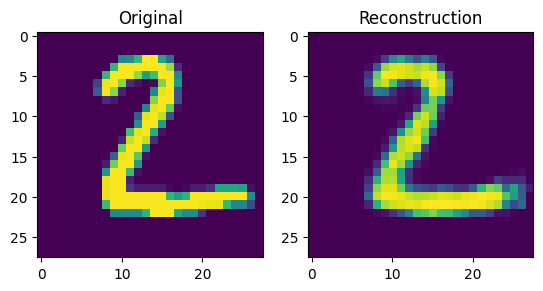

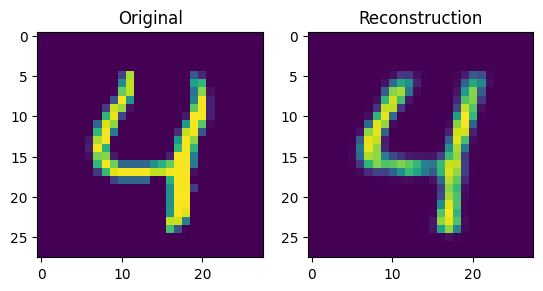

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

model.eval()

def show_image(x, idx, figure=True):
    if figure:
      fig = plt.figure()

    x = x.view(batch_size, 28, 28)
    plt.imshow(x[idx].cpu().numpy())

def show_comparison(x, x_hat, idx):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    show_image(x, idx, False)
    plt.title("Original")
    plt.subplot(1, 2, 2)
    show_image(x_hat, idx, False)
    plt.title("Reconstruction")

x, _ = next(iter(test_loader))
with torch.no_grad():
      x = x.view(batch_size, data_dim)
      x = x.to(device)

      x_hat, _, _ = model(x)

show_comparison(x, x_hat, 1) # digit 2
show_comparison(x, x_hat, 4) # digit 4

Because of how the decoder learns to create images from the latents (and is forced to represent a lot of the complexity), we can actually create generations from random noise with the decoder and yield distinguishable results.

Here, we do this, and I've cherry picked some nice examples (generated from random noise as the latent representations).

In [ ]:
from torchvision.utils import save_image, make_grid

with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = decoder(noise)

save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')


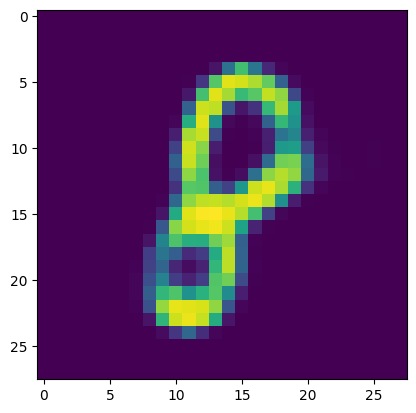

In [ ]:
show_image(generated_images, idx = 6)

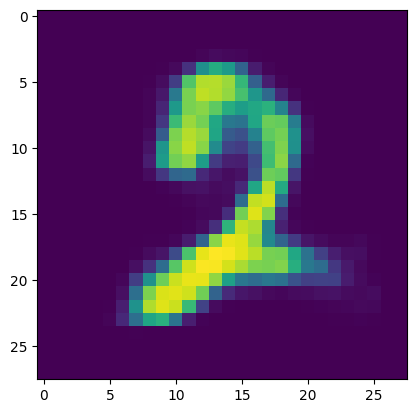

In [ ]:
show_image(generated_images, idx = 7)